# Solving integral analytically

In this project I study pure dephasing model $\rho$ where the dynamics are coverned by the decoherence function $\Gamma$. I evaluate $ \sigma_x(t) $ with different parameter values

For initial state $$\rho = \braket{+|+} $$ when $$\beta \rightarrow \infty$$ density matrix at time t is
$$ \rho(t) = \frac{1}{2} \begin{pmatrix}
1 & e^{-\Gamma (t)} \\
e^{-\Gamma (t)} & 1 
\end{pmatrix}$$
and Decoherence function is 
$$ \Gamma (t) = 4 \eta \omega_c^{1-s} \int_{0}^{\infty} \omega^{s-2} (1-\cos(\omega t)) e^{-\omega / \omega_c} \,d\omega.  $$

Using these we get that the expectation value of an obervable $ \sigma_x(t) $ is

$$ \braket{\sigma_x(t)} = tr(\sigma_x \rho(t)) = e^{-\Gamma(t)}$$

In [1]:
import sympy as smp
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.fft

from torch import nn
import torch.optim as optim

In [2]:
omega = smp.symbols('omega', positive = True, real = True)
omega_c = smp.symbols('omega_c', positive = True, real = True)
t = smp.symbols('t', positive = True, real = True)
s = smp.symbols('s', positive = True, real = True)
eta = smp.symbols('eta', positive = True, real = True)

#Integrand of the decoherence function
integrand = 4*eta*omega_c**(1-s)*omega**(s-2)*(1-smp.cos(omega*t))*smp.exp(-omega/omega_c)

In [5]:
#Decoherence function
gamma = smp.integrate(integrand, (omega, 0, smp.oo))

In [7]:
gamma

Piecewise((-4*2**(s - 2)*eta*omega_c**(1 - s)*omega_c**(s - 1)*t**(3 - s)*t**(s - 1)*(omega_c**2*t**2 + 1)**(1/2 - s/2)*cos((1 - s)*atan(omega_c*t))*gamma(s/2)*gamma(s/2 - 1/2)/(sqrt(pi)*t**2) + 4*eta*omega_c*omega_c**(1 - s)*omega_c**(s - 2)*gamma(s - 1), s > 1), (Integral(4*eta*omega**(s - 2)*omega_c**(1 - s)*(1 - cos(omega*t))*exp(-omega/omega_c), (omega, 0, oo)), True))

In [9]:
#Expectation value of sigma_x
sigma_func = smp.exp(-gamma)
sigma_func = smp.simplify(sigma_func)
sigma_ev = smp.lambdify((t,s, eta, omega_c), sigma_func)



In [11]:
sigma_func

Piecewise((exp(4*eta*((omega_c**2*t**2 + 1)**(1/2 - s/2)*cos((s - 1)*atan(omega_c*t)) - 1)*gamma(s - 1)), s > 1), (exp(4*eta*omega_c**(1 - s)*Integral(omega**(s - 2)*(cos(omega*t) - 1)*exp(-omega/omega_c), (omega, 0, oo))), True))

In [13]:
t_values = np.linspace(0, 40, 200)
s_sub_ohmic = np.linspace(0, 0.9, 10)
s_super_ohmic = np.linspace(1.01,4, 10)
s_ohmic = 1

#eta_val = 0.25
#omega_c_val = 0.5

eta_val = 0.25
omega_c_val = 0.5


sigma_sub_ohmic = np.array([[sigma_ev(t_val, s_val, eta_val, omega_c_val) for t_val in t_values] for s_val in s_sub_ohmic])

sigma_super_ohmic = np.array([[sigma_ev(t_val, s_val, eta_val, omega_c_val)  for t_val in t_values] for s_val in s_super_ohmic])

sigma_ohmic = np.array([sigma_ev(t_val, s_ohmic, eta_val, omega_c_val)  for t_val in t_values])

sigma_sub_ohmic = torch.from_numpy(sigma_sub_ohmic)
sigma_super_ohmic = torch.from_numpy(sigma_super_ohmic)
sigma_ohmic = torch.from_numpy(sigma_ohmic)




<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in scalar multiply
  return select([greater(s, 1),True], [exp(4*eta*((omega_c**2*t**2 + 1)**(1/2 - 1/2*s)*cos((s - 1)*arctan(omega_c*t)) - 1)*gamma(s - 1)),exp(4*eta*omega_c**(1 - s)*quad(lambda omega: omega**(s - 2)*(cos(omega*t) - 1)*exp(-omega/omega_c), 0, inf)[0])], default=nan)
<lambdifygenerated-1>:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return select([greater(s, 1),True], [exp(4*eta*((omega_c**2*t**2 + 1)**(1/2 - 1/2*s)*cos((s - 1)*arctan(omega_c*t)) - 1)*gamma(s - 1)),exp(4*eta*omega_c**(1 - s)*qua

In [15]:
print(type(sigma_ev(5, 1, 0.25, 0.5)))

<class 'numpy.ndarray'>


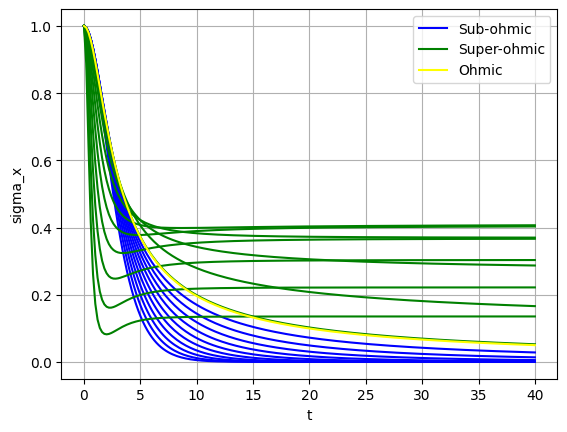

In [17]:
fig = plt.figure()
for i in range(sigma_sub_ohmic.shape[0]):
    plt.plot(t_values, sigma_sub_ohmic[i], color = 'blue')
    
for j in range(sigma_super_ohmic.shape[0]):
    plt.plot(t_values, sigma_super_ohmic[j], color = 'green')

plt.plot(t_values, sigma_ohmic, color = 'yellow')

plt.plot([], [], color = 'blue', label="Sub-ohmic")
plt.plot([], [], color = 'green', label = "Super-ohmic")
plt.plot([], [], color = 'yellow', label = "Ohmic")

plt.grid()
plt.ylabel("sigma_x")
plt.xlabel("t")
plt.legend()

In [19]:
#Time interval
t_values = np.linspace(0.01, 40, 200)

#Parameter ranges for eta,  omega_c, s for different couplings
eta_values = np.linspace(0.1,0.3,20)
omega_c_values = np.linspace(0.1,0.3,20)
s_sub_ohmic = np.linspace(0.1, 0.99, 10)
s_super_ohmic = np.linspace(1.0,4, 10)

s_ohmic = 1


sigma_sub_ohmic = np.array([[sigma_ev(t_val, s_val, eta_val, omega_c_val) for t_val in t_values] for s_val in s_sub_ohmic for omega_c_val in omega_c_values for eta_val in eta_values])
print("First")
sigma_super_ohmic = np.array([[sigma_ev(t_val, s_val, eta_val, omega_c_val)  for t_val in t_values] for s_val in s_super_ohmic for omega_c_val in omega_c_values for eta_val in eta_values])
print("Second")
sigma_ohmic = np.array([[sigma_ev(t_val, s_ohmic, eta_val, omega_c_val)  for t_val in t_values] for eta_val in eta_values for omega_c_val in omega_c_values])


sigma_sub_ohmic = torch.from_numpy(sigma_sub_ohmic)
sigma_super_ohmic = torch.from_numpy(sigma_super_ohmic)
sigma_ohmic = torch.from_numpy(sigma_ohmic)




First
Second


In [79]:
print(sigma_ohmic.shape)
print(sigma_super_ohmic.shape)

torch.Size([400, 200])
torch.Size([4000, 200])


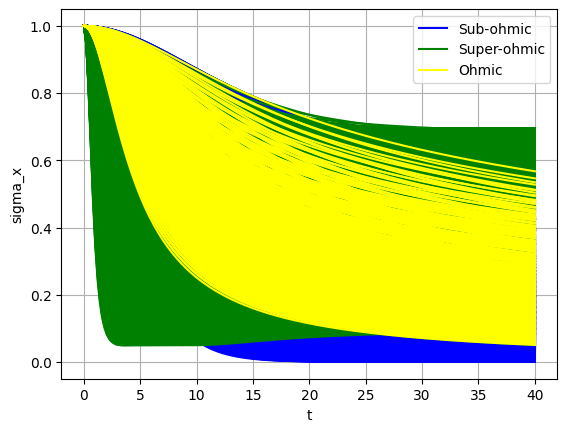

In [23]:
fig = plt.figure()
for i in range(sigma_sub_ohmic.shape[0]):
    plt.plot(t_values, sigma_sub_ohmic[i], color = 'blue')
    
for j in range(sigma_super_ohmic.shape[0]):
    plt.plot(t_values, sigma_super_ohmic[j], color = 'green')

for k in range(sigma_ohmic.shape[0]):
    plt.plot(t_values, sigma_ohmic[k], color = 'yellow')

plt.plot([], [], color = 'blue', label="Sub-ohmic")
plt.plot([], [], color = 'green', label = "Super-ohmic")
plt.plot([], [], color = 'yellow', label = "Ohmic")

plt.grid()
plt.ylabel("sigma_x")
plt.xlabel("t")
plt.legend()

# Neural network

Neural network model is trained to identify ohmic, sub-ohmis or superohmic baths using signals as data from last section.

In [25]:
import torch
import sklearn.model_selection as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import torch.fft

from torch import nn
import torch.optim as optim

In [83]:
X = []
y = []

#For each signal is Fourier transformed and real part and imaginary are separated
for i in range(int(sigma_ohmic.shape[0]/2)):
    #for i in range(800):
    DFT_super_ohmic = torch.fft.fft(sigma_super_ohmic[i])
    X.append(torch.hstack([DFT_super_ohmic.real, DFT_super_ohmic.imag]))
    y.append(0)

    DFT_sub_ohmic = torch.fft.fft(sigma_sub_ohmic[i])
    X.append(torch.hstack([DFT_sub_ohmic.real, DFT_sub_ohmic.imag]))
    y.append(1)


for j in range(sigma_ohmic.shape[0]):
        DFT_ohmic = torch.fft.fft(sigma_ohmic[j])
        X.append(torch.hstack([DFT_ohmic.real, DFT_ohmic.imag]))
        y.append(2)


X = torch.stack(X).float()
y = torch.tensor(y, dtype=torch.long)


In [87]:
print(X.shape)
print(y.shape)


torch.Size([800, 400])
torch.Size([800])


In [38]:
#freq = np.fft.fftfreq(len(t_values), d = t_values[-1]/N)
#plt.figure()
#plt.plot(freq, DFT_sub_ohmic.real, freq, DFT_sub_ohmic.imag)
#plt.show()

In [89]:
N = X.shape[0]
M = X.shape[1]
input_dim = X.shape[1]
num_classes = 3

X_train, X_test, y_train, y_test = sk.train_test_split(X, y, test_size=0.33, random_state=42)



In [91]:
y_train.dtype

torch.int64

In [94]:
# Neural Network model
class OhmicityClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OhmicityClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 250),
            nn.ReLU(),
            nn.Linear(250, 80),
            nn.ReLU(),
            nn.Linear(80,num_classes)
        )

    def forward(self, x):
        return self.net(x)        
    

In [96]:
# Earlystopping is used to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [98]:
model = OhmicityClassifier(input_dim, num_classes)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
early_stopping = EarlyStopping(patience = 5, delta = 0.01)

OhmicityClassifier(
  (net): Sequential(
    (0): Linear(in_features=400, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=2, bias=True)
  )
)


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OhmicityClassifier(
  (net): Sequential(
    (0): Linear(in_features=400, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=2, bias=True)
  )
)

In [102]:
loss_values = []

min_valid_loss = np.inf

#Model is trained
for epoch in range(100):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train)):
        xt, yt = X_train[i], y_train[i]

        #Clear gradients
        optimizer.zero_grad()
        #Forward pass
        output = model(xt)
        #Find loss
        loss = criterion(output, yt)

        #Calculate gradients
        loss.backward()

        #Update weights
        optimizer.step()

        total_loss += loss.item()
        
    loss_values.append(total_loss/ len(X_train))
    print(f"Epoch {epoch + 1}, \t\t Loss: {total_loss / len(X_train)}")

    
    valid_loss = 0.0
    model.eval()

    with torch.no_grad():
        for j in range(0, len(X_test)):
            xe, ye = X_test[j], y_test[j]
            test_output = model(xe)
            loss = criterion(test_output, ye)
            valid_loss += loss.item()

    valid_loss /= len(X_test)

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

early_stopping.load_best_model(model)





   # if min_valid_loss > valid_loss:
    #    print(f"Validation loss decreased {min_valid_loss} --> {valid_loss}")
    #    min_valid_loss = valid_loss
    


Epoch 1, 		 Loss: 0.6023457033643081
Epoch 2, 		 Loss: 0.5030053288210183
Epoch 3, 		 Loss: 0.4636752370557289
Epoch 4, 		 Loss: 0.4489529544379868
Epoch 5, 		 Loss: 0.4412411986155185
Epoch 6, 		 Loss: 0.43686883295486584
Epoch 7, 		 Loss: 0.4354409379702159
Epoch 8, 		 Loss: 0.43025664112977197
Epoch 9, 		 Loss: 0.4290482965871386
Epoch 10, 		 Loss: 0.42854924132368083
Epoch 11, 		 Loss: 0.4252585661925511
Epoch 12, 		 Loss: 0.4259307607991009
Epoch 13, 		 Loss: 0.4253563540833464
Epoch 14, 		 Loss: 0.420945843664752
Epoch 15, 		 Loss: 0.42155842362284496
Epoch 16, 		 Loss: 0.4183253799335998
Epoch 17, 		 Loss: 0.4173766809008293
Epoch 18, 		 Loss: 0.4180415561685509
Early stopping


In [104]:
model.eval()
correct = 0
total = 0

#Model is evaluated and final accuracy is calculated
with torch.no_grad():
    test_output = model(X_test)
    predictions = torch.argmax(test_output, dim=1)
    correct += (predictions == y_test).sum().item()
    total += y_test.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7235


In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       138
           1       0.71      0.71      0.71       126

    accuracy                           0.72       264
   macro avg       0.72      0.72      0.72       264
weighted avg       0.72      0.72      0.72       264



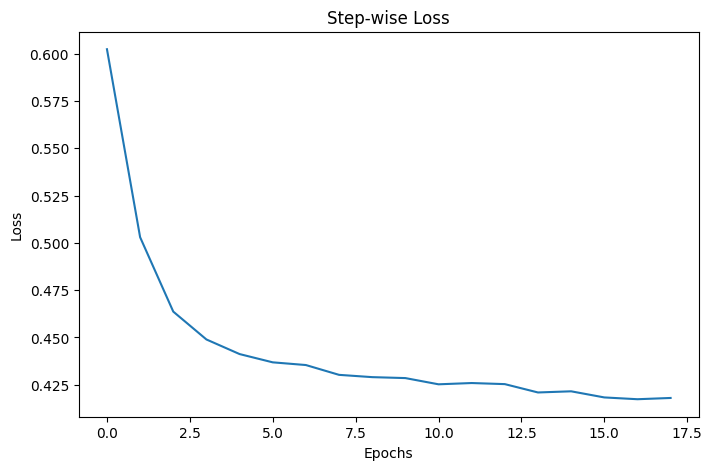

In [108]:
#Graph of loss vs epoch number
step = range(len(loss_values))
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()